<a href="https://colab.research.google.com/github/kunalpagarey/PyTocrh_Tutorial/blob/master/PyTorch_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
train_transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                transforms.ColorJitter(brightness=0.2, saturation=0.2, contrast=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10('./data/', train=True, transform=train_transform, download=True)
val_data = datasets.CIFAR10('./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
val_loader = DataLoader(val_data, batch_size=100)

def convert_image(img):
    image = img.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image


Files already downloaded and verified
Files already downloaded and verified


In [0]:
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'house', 'ship', 'truck']

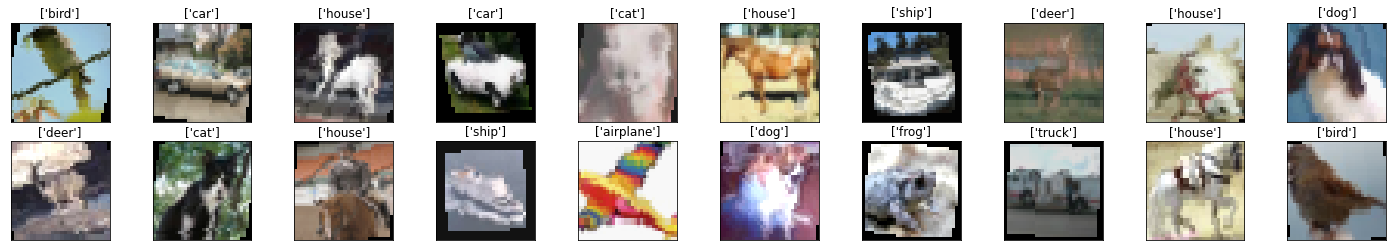

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(convert_image(images[idx]))
    ax.set_title([classes[labels[idx].item()]])

In [0]:
# LeNet implementation

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [15]:
model = LeNet().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [16]:
epochs = 15
t_losses = []
t_accuracy = []
v_losses = []
v_accuracy = []
for e in range(epochs):
    te_loss = 0.0
    te_correct = 0.0
    ve_loss = 0.0
    ve_correct = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1)

        te_loss += loss.item()
        te_correct += torch.sum(pred == labels)

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, pred = torch.max(outputs, 1)

            ve_loss += loss.item()
            ve_correct += torch.sum(pred == labels)
    
    te_loss = te_loss/len(train_loader)
    te_correct = te_correct/len(train_loader)
    ve_loss = ve_loss/len(val_loader)
    ve_correct = ve_correct/len(val_loader)

    t_losses.append(te_loss)
    t_accuracy.append(te_correct)
    v_losses.append(ve_loss)
    v_accuracy.append(ve_correct)
    print("Epoch: {}, Train: Loss={:0.4f}, Accuracy={:0.4f}, Val: Loss={:0.4f}"\
          ", Accuracy={:0.4f}".format(e, te_loss, te_correct.item(), ve_loss,
                                      ve_correct.item()))

Epoch: 0, Train: Loss=1.6888, Accuracy=38.0940, Val: Loss=1.4320, Accuracy=48.5500
Epoch: 1, Train: Loss=1.3924, Accuracy=49.5140, Val: Loss=1.2240, Accuracy=56.1500
Epoch: 2, Train: Loss=1.2718, Accuracy=54.6300, Val: Loss=1.1387, Accuracy=59.0800
Epoch: 3, Train: Loss=1.1840, Accuracy=58.0600, Val: Loss=1.0626, Accuracy=62.2100
Epoch: 4, Train: Loss=1.1167, Accuracy=60.6520, Val: Loss=1.0094, Accuracy=64.5800
Epoch: 5, Train: Loss=1.0698, Accuracy=62.1480, Val: Loss=0.9694, Accuracy=66.3800
Epoch: 6, Train: Loss=1.0302, Accuracy=63.6700, Val: Loss=0.9397, Accuracy=67.1200
Epoch: 7, Train: Loss=0.9943, Accuracy=65.0180, Val: Loss=0.9023, Accuracy=68.1700
Epoch: 8, Train: Loss=0.9701, Accuracy=65.8080, Val: Loss=0.8898, Accuracy=68.8700
Epoch: 9, Train: Loss=0.9387, Accuracy=66.8360, Val: Loss=0.8654, Accuracy=69.8200
Epoch: 10, Train: Loss=0.9218, Accuracy=67.8060, Val: Loss=0.8642, Accuracy=69.9900
Epoch: 11, Train: Loss=0.9043, Accuracy=68.3740, Val: Loss=0.8407, Accuracy=71.2600
Ep

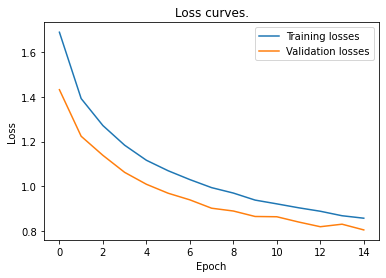

In [17]:
plt.plot(t_losses, label="Training losses")
plt.plot(v_losses, label="Validation losses")
plt.title("Loss curves.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

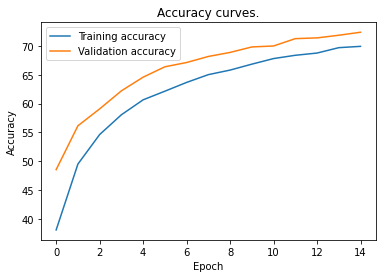

In [18]:
plt.plot(t_accuracy, label="Training accuracy")
plt.plot(v_accuracy, label="Validation accuracy")
plt.title("Accuracy curves.")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [0]:
import PIL.ImageOps as ops
from PIL import Image
import requests

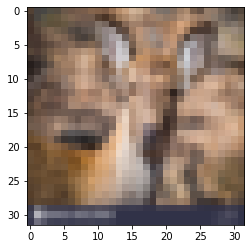

In [23]:
url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'

response = requests.get(url, stream=True)
img = Image.open(response.raw)
img = transform(img)
plt.imshow(convert_image(img))

In [24]:
im = img.to(device)
im = im.unsqueeze(0)
out = model(im)
_, prediction = torch.max(out, 1)
print(classes[prediction.item()])

deer


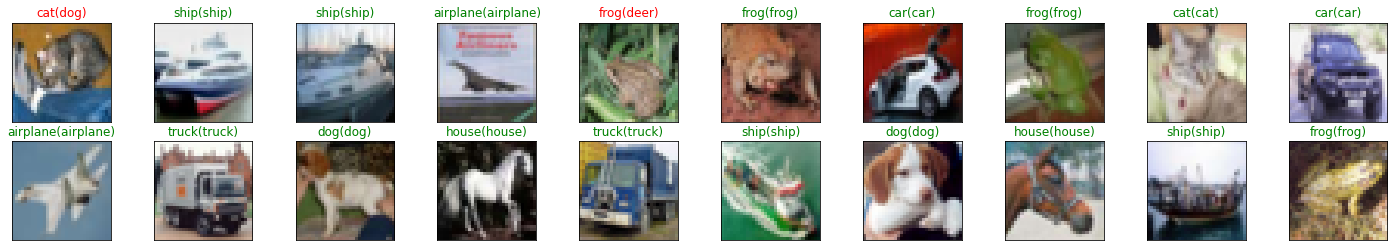

In [22]:
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
logits = model(images)
_, predictions = torch.max(logits, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(convert_image(images[idx]))
    ax.set_title("{}({})".format(str(classes[labels[idx].item()]), str(classes[predictions[idx].item()])), 
                 color="green" if predictions[idx] == labels[idx] else "red")